In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
from pandas.tseries.offsets import CustomBusinessDay
from pandas.tseries.holiday import USFederalHolidayCalendar
import pandas_datareader.data as web
import warnings
warnings.filterwarnings("ignore")
from functions import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# reload packages
import importlib
import functions
importlib.reload(functions)

<module 'functions' from 'c:\\Users\\yanis\\OneDrive\\Desktop\\UNI\\M.Sc\\AUT 2024\\Machine Learning\\Partie 2\\Projet_2\\Straddle_hedging_project\\functions.py'>

In [35]:
start_date = '2005-01-01'
end_date = '2023-08-31'

training_start_date = '2007-01-01'
training_end_date = '2015-12-31'
test_start_date = '2016-01-01'
test_end_date = '2023-08-31'

In [36]:
# Read data from CSV
data = pd.read_csv('filtered_data_cleaned.csv')
data.set_index('Date', inplace=True)
data.head()

,exdate,cp_flag,strike_price,best_bid,best_offer,volume,impl_volatility,delta,gamma,vega,theta,optionid,contract_size,D to Expiration,Close,Moneyness
Date,,,,,,,,,,,,,,,,
2000-01-03,2000-01-22,P,1465.0,30.000,32.000,68,0.218037,-0.521459,0.005654,128.7359,-237.8190,10526329,100,19,1455.219971,1.006721
2000-01-03,2000-01-22,P,1440.0,19.875,21.125,691,0.227943,-0.385638,0.005192,123.5883,-251.1784,10563021,100,19,1455.219971,0.989541
2000-01-03,2000-01-22,C,1460.0,23.375,25.375,386,0.191068,0.505087,0.006461,128.9120,-291.8110,10949021,100,19,1455.219971,1.003285
2000-01-03,2000-01-22,C,1450.0,29.125,32.000,1312,0.198929,0.567313,0.006117,127.0829,-303.3932,11070856,100,19,1455.219971,0.996413
2000-01-03,2000-01-22,C,1465.0,20.625,22.625,0,0.187986,0.472246,0.006551,128.6103,-284.5414,11274505,100,19,1455.219971,1.006721


In [37]:
data = data.loc[start_date:end_date]
option_df = data
data.index = pd.to_datetime(data.index)

# Get midprice for all data
data['Midprice'] = (data['best_bid'] + data['best_offer']) / 2
data.index

DatetimeIndex(['2005-01-03', '2005-01-03', '2005-01-03', '2005-01-03',
               '2005-01-03', '2005-01-03', '2005-01-03', '2005-01-03',
               '2005-01-03', '2005-01-03',
               ...
               '2023-08-31', '2023-08-31', '2023-08-31', '2023-08-31',
               '2023-08-31', '2023-08-31', '2023-08-31', '2023-08-31',
               '2023-08-31', '2023-08-31'],
              dtype='datetime64[ns]', name='Date', length=405196, freq=None)

In [38]:
atm_options = create_straddle_tracking_dataset(data)
straddle_returns = compute_straddle_returns(atm_options, data)
straddle_returns

Processing initiation Date: 2005-01-20, Maturity: 1D
No data available after initiation for Date: 2005-01-20, Maturity: 1D. Skipping.
Processing initiation Date: 2005-01-20, Maturity: 1M
Processing initiation Date: 2005-02-17, Maturity: 1D
No data available after initiation for Date: 2005-02-17, Maturity: 1D. Skipping.
Processing initiation Date: 2005-02-17, Maturity: 1M
Processing initiation Date: 2005-03-17, Maturity: 1D
No data available after initiation for Date: 2005-03-17, Maturity: 1D. Skipping.
Processing initiation Date: 2005-03-17, Maturity: 1M
Processing initiation Date: 2005-04-14, Maturity: 1D
No data available after initiation for Date: 2005-04-14, Maturity: 1D. Skipping.
Processing initiation Date: 2005-04-21, Maturity: 1M
Processing initiation Date: 2005-05-19, Maturity: 1D
No data available after initiation for Date: 2005-05-19, Maturity: 1D. Skipping.
Processing initiation Date: 2005-05-19, Maturity: 1M
Processing initiation Date: 2005-06-16, Maturity: 1D
No data avai

,Initiation_Date,Maturity,Expiration_Date,Return
0,2005-01-20,1M,2005-02-19,0.021558
1,2005-02-17,1M,2005-03-19,-0.008778
2,2005-03-17,1M,2005-04-16,-0.023660
3,2005-04-21,1M,2005-05-21,0.026837
4,2005-05-19,1M,2005-06-18,0.016691
...,...,...,...,...
3741,2023-08-29,1D,2023-08-31,0.002230
3742,2023-08-29,1W,2023-09-05,0.002230
3743,2023-08-30,1D,2023-09-01,-0.001597
3744,2023-08-30,1M,2023-09-29,-0.001597


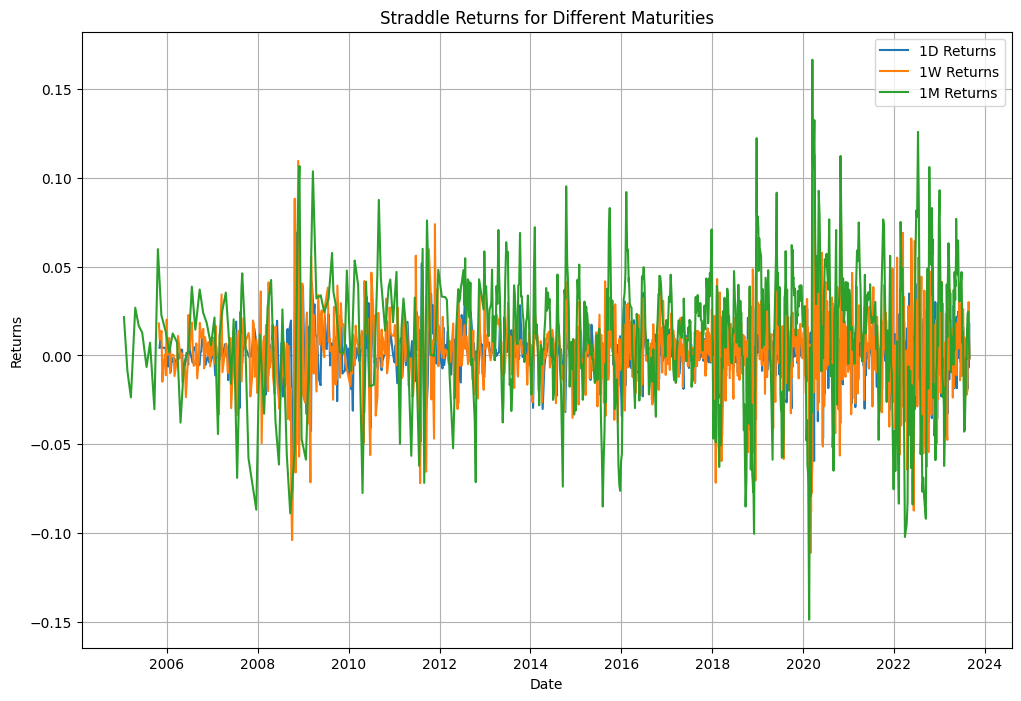

In [39]:
returns_dict = {}
maturities = ['1D', '1W', '1M']

plt.figure(figsize=(12, 8))

for maturity in maturities:
    # Filter the returns based on maturity
    returns_dict[maturity] = straddle_returns[straddle_returns["Maturity"] == maturity]
    returns_dict[maturity].set_index('Initiation_Date', inplace=True)
    
    # Plot the returns
    plt.plot(returns_dict[maturity].index, returns_dict[maturity]['Return'], label=f'{maturity} Returns')

plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Straddle Returns for Different Maturities')
plt.legend()
plt.grid()
plt.show()

In [40]:
returns_dict

{'1D':                 Maturity Expiration_Date    Return
 Initiation_Date                                   
 2005-11-02            1D      2005-11-04  0.004264
 2005-11-09            1D      2005-11-11  0.008446
 2005-11-17            1D      2005-11-19  0.004401
 2005-12-21            1D      2005-12-23  0.004221
 2005-12-28            1D      2005-12-30 -0.002981
 ...                  ...             ...       ...
 2023-08-22            1D      2023-08-24 -0.002562
 2023-08-23            1D      2023-08-25 -0.006830
 2023-08-28            1D      2023-08-30  0.018397
 2023-08-29            1D      2023-08-31  0.002230
 2023-08-30            1D      2023-09-01 -0.001597
 
 [1216 rows x 3 columns],
 '1W':                 Maturity Expiration_Date    Return
 Initiation_Date                                   
 2005-10-28            1W      2005-11-04  0.017965
 2005-11-04            1W      2005-11-11  0.008868
 2005-11-18            1W      2005-11-25  0.013891
 2005-11-25            1